In [311]:
import pandas as pd
import pyodbc
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from datetime import date
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import catboost as cat
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

##### Os dados do projeto são de uma empresa real, as informações privadas serão ocultas.
---
##### A principal função dessa análise é facilitar a visualização de resultados da segunda-feira comparado com outras semanas. A partir desse resultado uma ferramenta de machine learning faz a previsão de demanda.
---
##### Esse código é rodado toda terça-feira no primeiro horário e enviado para o comercial da empresa.

# Conexão SQL

In [2]:
server = ######## 
database = ######## 
username = ########  
password = ######## 

In [7]:
cnxn = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [8]:
cursor = cnxn.cursor()
# Sample select query 
cursor.execute("SELECT @@version;") 
row = cursor.fetchone() 
while row: 
    print(row[0]) 
    row = cursor.fetchone()

Microsoft SQL Server 2019 (RTM) - 15.0.2000.5 (X64) 
	Sep 24 2019 13:48:23 
	Copyright (C) 2019 Microsoft Corporation
	Express Edition (64-bit) on Windows Server 2016 Standard 10.0 <X64> (Build 14393: ) (Hypervisor)



In [9]:
query_ecm_full = '''
select *,

CASE
WHEN Vendedor = 'AMERICANAS' THEN 'B2W'
WHEN Vendedor = 'SHOPTIME' THEN 'B2W'
WHEN Vendedor = 'SUBMARINO' THEN 'B2W'
WHEN Vendedor = 'AMAZON' THEN 'AMAZON'
WHEN Vendedor = 'CARREFOUR' THEN 'MKTPLACE'
WHEN Vendedor = 'CONECTA_LA' THEN 'CONECTA LA'
WHEN Vendedor = 'KABUM' THEN 'KABUM'
WHEN Vendedor = 'LOJA_VIVO' THEN 'MKTPLACE'
WHEN Vendedor = 'MADEIRA MADEIRA' THEN 'MKTPLACE'
WHEN Vendedor = 'NOVO MUNDO' THEN 'MKTPLACE'
WHEN Vendedor = 'OLIST' THEN 'OLIST'
WHEN Vendedor = 'RAPPI' THEN 'MKTPLACE'
WHEN Vendedor = 'SHOPEE' THEN 'SHOPEE'
WHEN Vendedor = 'VIA VAREJO (CNOVA)' THEN 'VIA VAREJO (CNOVA)'
WHEN Vendedor = 'ECM EMPRESAS' THEN 'ECM EMPRESAS'
WHEN Vendedor = 'KAZUK' THEN 'KAZUK'
WHEN Vendedor = 'KZK ML' THEN 'KAZUK'
WHEN Vendedor = 'MAGAZINE LUIZA' THEN 'MAGALU'
WHEN Vendedor = 'MERCADO LIVRE' THEN 'MERCADO LIVRE'
WHEN Vendedor = 'ML FULL' THEN 'MERCADO LIVRE FULL'
WHEN Vendedor = 'BACKUP' THEN 'OUTROS'
WHEN Vendedor = 'CD PRESENCIAL' THEN 'ESPACO ECMSCREEN'
WHEN Vendedor = 'INDICAÇÃO' THEN 'OUTROS'
WHEN Vendedor = 'ALICE LEAL' THEN 'REVENDA'
WHEN Vendedor = 'ALINE DIAS' THEN 'REVENDA'
WHEN Vendedor = 'BRUNO T' THEN 'REVENDA'
WHEN Vendedor = 'FERNANDO M' THEN 'REVENDA'
WHEN Vendedor = 'FLAVIO' THEN 'REVENDA'
WHEN Vendedor = 'JOSIANE' THEN 'REVENDA'
WHEN Vendedor = 'LEANDRO' THEN 'REVENDA'
WHEN Vendedor = 'WESLEY' THEN 'REVENDA'
WHEN Vendedor = 'REENVIO' THEN 'RMA'
WHEN Vendedor = 'RMA' THEN 'RMA'
WHEN Vendedor = 'MAGENTO' THEN 'MAGENTO'
WHEN Vendedor = 'PJ SITE' THEN 'SITE'
WHEN Vendedor = 'REVENDA SITE' THEN 'SITE'
WHEN Vendedor = 'SITE' THEN 'SITE'
END as 'MÉDIO_CANAL'


from base_hist_custo_fixo 

'''
df_hist = pd.read_sql_query(query_ecm_full, cnxn)

# Criando DF com informações válidas

In [10]:
mask_dev = df_hist['Devolução'] == 0
ecm_full = df_hist[mask_dev]

mask_tipo = ecm_full['Tipo'] == 'Real'
ecm_full = ecm_full[mask_tipo].reset_index()

ecm_full = ecm_full.sort_values(by = 'Data Emissão').reset_index()

# Criando DF para análise dos dados:
## DF criado:
    - ecm_vendas = todas as vendas da empresa
    - vends_ontem = df com as vendas realizadas ontem (segunda-feira)
    - relatorio_segunda = relatório final. Uma visualização do relatório está disponibilizada no final do código

In [635]:
# Selecionado as colunas que vou utilizar da base de dados
ecm_vendas = ecm_full[['Tipo', 'Data Emissão',
                       'MÉDIO_CANAL', 'Código', 'Volume / Mês', 'Vr Unitário', 'Margem Contribuição Sem Imposto (R$)']]

# Na coluna tipo, existem pedidos de teste para testar o sistema. Vou filtrar apenas para os pedidos reais
mask_tipo = ecm_full['Tipo'] == 'Real'
ecm_vendas = ecm_vendas[mask_tipo]
# Transformando o preço em float
ecm_vendas['Vr Unitário'] = ecm_vendas['Vr Unitário'].map(float)
# Mudando o  nome da data do pedido
ecm_vendas = ecm_vendas.rename(columns={'Data Emissão' : 'data'})
# dropando a coluna Tipo
ecm_vendas = ecm_vendas.drop(columns = ['Tipo'])

# Colocando a coluna de data apenas para data, sem horário. Para evitar problemas mais para frente
ecm_vendas['data'] = [datetime.date(data) for data in ecm_vendas['data']]

In [646]:
# Criando um DF com as informações de ontem
# estou usando uma terça-feira aleatória para fazer o modelo
hoje = date(2022, 4, 26)
# hoje = datetime.today()
delta = timedelta(days = 1)
ontem = hoje - delta
#ontem = datetime.date(ontem)
mask_ontem = ecm_vendas['data'] == ontem
df_ontem = ecm_vendas[mask_ontem]

# Transformando a margem de contribuição em float
df_ontem['Margem Contribuição Sem Imposto (R$)'] = df_ontem['Margem Contribuição Sem Imposto (R$)'].map(float)

# Agrupando as vendas ontem por SKU e por canal de venda:
    # total de vendas ontem
    # média de preço ontem
    # Margem de contribuição total de ontem
vendas_ontem = df_ontem.groupby(by = ['MÉDIO_CANAL', 'Código'], as_index = False).agg(
    vendas_ontem = pd.NamedAgg(column = 'Volume / Mês', aggfunc = 'sum'),
    preço_unid_ontem = pd.NamedAgg(column = 'Vr Unitário', aggfunc = 'mean'),
    Total_MC_ontem = pd.NamedAgg(column = 'Margem Contribuição Sem Imposto (R$)', aggfunc = 'sum'))

# Replicando o que fiz acima para 1, 2 e 3 segundas antes
    # Criando DF para 1 segunda antes
delta_1s = timedelta(days = 8)
delta_1s = hoje - delta_1s
mask_1s = ecm_vendas['data'] == delta_1s
df_1s = ecm_vendas[mask_1s]

    # Criando DF para 2 segundas antes
delta_2s = timedelta(days = 15)
delta_2s = hoje - delta_2s
mask_2s = ecm_vendas['data'] == delta_2s
df_2s = ecm_vendas[mask_2s]

 # Criando DF para 3 segundas antes
delta_3s = timedelta(days = 22)
delta_3s = hoje - delta_3s
mask_3s = ecm_vendas['data'] == delta_3s
df_3s = ecm_vendas[mask_3s]

# Transformando margem de contribuição em float
df_1s['Margem Contribuição Sem Imposto (R$)'] = df_1s['Margem Contribuição Sem Imposto (R$)'].map(float)
df_2s['Margem Contribuição Sem Imposto (R$)'] = df_2s['Margem Contribuição Sem Imposto (R$)'].map(float)
df_3s['Margem Contribuição Sem Imposto (R$)'] = df_3s['Margem Contribuição Sem Imposto (R$)'].map(float)

# Agrupando as vendas de 1 segunda por SKU e por canal de venda:
    # total de vendas 
    # média de preço 
    # Margem de contribuição total 
vendas_1s = df_1s.groupby(by = ['MÉDIO_CANAL', 'Código'], as_index = False).agg(
    vendas_1s = pd.NamedAgg(column = 'Volume / Mês', aggfunc = 'sum'),
    preço_unid_1s = pd.NamedAgg(column = 'Vr Unitário', aggfunc = 'mean'),
    Total_MC_1s = pd.NamedAgg(column = 'Margem Contribuição Sem Imposto (R$)', aggfunc = 'sum'))

# Agrupando as vendas de 2 segundas atrás por SKU e por canal de venda:
    # total de vendas 
    # média de preço 
    # Margem de contribuição total
vendas_2s = df_2s.groupby(by = ['MÉDIO_CANAL', 'Código'], as_index = False).agg(
    vendas_2s = pd.NamedAgg(column = 'Volume / Mês', aggfunc = 'sum'),
    preço_unid_2s = pd.NamedAgg(column = 'Vr Unitário', aggfunc = 'mean'),
    Total_MC_2s = pd.NamedAgg(column = 'Margem Contribuição Sem Imposto (R$)', aggfunc = 'sum'))

# Agrupando as vendas de 3 segundas atrás por SKU e por canal de venda:
    # total de vendas 
    # média de preço 
    # Margem de contribuição total
vendas_3s = df_3s.groupby(by = ['MÉDIO_CANAL', 'Código'], as_index = False).agg(
    vendas_3s = pd.NamedAgg(column = 'Volume / Mês', aggfunc = 'sum'),
    preço_unid_3s = pd.NamedAgg(column = 'Vr Unitário', aggfunc = 'mean'),
    Total_MC_3s = pd.NamedAgg(column = 'Margem Contribuição Sem Imposto (R$)', aggfunc = 'sum'))

# Utilizando merge para agrupadar todas as informações em um único DF
t = vendas_ontem.merge(vendas_1s, on = ['MÉDIO_CANAL', 'Código'], how = 'left')
t1 = t.merge(vendas_2s, on = ['MÉDIO_CANAL', 'Código'], how = 'left')
t2 = t1.merge(vendas_3s, on = ['MÉDIO_CANAL', 'Código'], how = 'left')

# Criando o relatório das segundas em uma ordem que facilite a visualização dos dados:
relatorio_segunda = pd.DataFrame({'Canal' : t2['MÉDIO_CANAL'], 'Código' : t2['Código'],
                                  'Vendas Ontem' : t2['vendas_ontem'], 
                                  'Vendas 1seg' : t2['vendas_1s'], 
                                  'Vendas 2seg' : t2['vendas_2s'],
                                  'Vendas 3seg' : t2['vendas_3s'],
                                  'Preço Ontem' : t2['preço_unid_ontem'],                                  
                                  'Preço 1seg' : t2['preço_unid_1s'],
                                  'Preço 2seg' : t2['preço_unid_1s'], 
                                  'Preço 3seg' : t2['preço_unid_3s'],
                                  'MC Ontem' : t2['Total_MC_ontem'],
                                  'MC 1seg' : t2['Total_MC_1s'],
                                  'MC 2seg' : t2['Total_MC_2s'],
                                  'MC 3seg' : t2['Total_MC_3s']})

# zerando os valores com NA no relatório
relatorio_segunda = relatorio_segunda.fillna(0)

# Ordenar pelos produtos que tiveram maios margem de contribuição negativa para análise mais urgente
relatorio_segunda['Diferença MC (Ontem / 1seg)'] =  relatorio_segunda['MC Ontem'] - relatorio_segunda['MC 1seg']
relatorio_segunda = relatorio_segunda.sort_values(by = 'Diferença MC (Ontem / 1seg)')

# Arrumando a visualização do relatório
relatorio_segunda['Vendas 1seg'] = relatorio_segunda['Vendas 1seg'].map(int)
relatorio_segunda['Vendas 2seg'] = relatorio_segunda['Vendas 2seg'].map(int)
relatorio_segunda['Vendas 3seg'] = relatorio_segunda['Vendas 3seg'].map(int)
relatorio_segunda['Vendas Ontem'] = relatorio_segunda['Vendas Ontem'].map(int)
relatorio_segunda['Preço Ontem'] = relatorio_segunda['Preço Ontem'].round(2)
relatorio_segunda['Preço 1seg'] = relatorio_segunda['Preço 1seg'].round(2)
relatorio_segunda['Preço 2seg'] = relatorio_segunda['Preço 2seg'].round(2)
relatorio_segunda['Preço 3seg'] = relatorio_segunda['Preço 3seg'].round(2)

<ipython-input-646-56a7488aeea2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ontem['Margem Contribuição Sem Imposto (R$)'] = df_ontem['Margem Contribuição Sem Imposto (R$)'].map(float)
<ipython-input-646-56a7488aeea2>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1s['Margem Contribuição Sem Imposto (R$)'] = df_1s['Margem Contribuição Sem Imposto (R$)'].map(float)
<ipython-input-646-56a7488aeea2>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [647]:
relatorio_segunda

,Canal,Código,Vendas Ontem,Vendas 1seg,Vendas 2seg,Vendas 3seg,Preço Ontem,Preço 1seg,Preço 2seg,Preço 3seg,MC Ontem,MC 1seg,MC 2seg,MC 3seg,Diferença MC (Ontem / 1seg)
178,MERCADO LIVRE FULL,121465,2,12,9,8,703.14,742.72,742.72,738.71,290.84,2156.88,1777.28,1459.98,-1866.04
317,SITE,100763,1,9,3,5,258.95,258.95,258.95,258.95,92.67,900.58,256.33,478.89,-807.91
15,B2W,100763,3,12,11,9,289.48,278.20,278.20,278.20,237.74,800.32,749.45,546.37,-562.58
162,MERCADO LIVRE FULL,101000,10,23,15,7,78.57,78.57,78.57,78.57,176.31,556.41,278.31,130.01,-380.10
90,MERCADO LIVRE,100588,3,23,9,8,184.29,159.40,159.40,184.29,112.74,475.83,178.09,141.87,-363.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,MERCADO LIVRE,100059,1,19,2,1,447.17,471.40,471.40,677.36,8.21,-366.80,221.09,109.43,375.01
237,RMA,100097,2,0,0,1,649.13,0.00,0.00,754.29,430.48,0.00,0.00,320.21,430.48
128,MERCADO LIVRE FULL,100059,7,8,2,7,544.82,447.17,447.17,609.12,223.83,-224.42,252.72,466.40,448.25
188,REVENDA,100215,3,0,1,10,682.15,0.00,0.00,716.09,526.67,0.00,186.79,1482.01,526.67


# Criando DF com colunas de interesse

In [677]:
df_mod = ecm_full[[ 'Data Emissão', 'MÉDIO_CANAL', 'Código', 'Dia', 'Mês', 'Ano', 'Categoria', 
                   'Vr Unitário', 'Volume / Mês']]

## Criando colunas de data

In [678]:
# Criando coluna com a semana do ano
df_mod['semana'] = df_mod['Data Emissão'].apply(lambda x: x.strftime("%U"))

# Criando a coluna com o dia da semana: 0 = segunda / 6 = domingo
df_mod['weekday'] = df_mod['Data Emissão'].apply(lambda x: x.weekday())

<ipython-input-678-7665dd17e5f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['semana'] = df_mod['Data Emissão'].apply(lambda x: x.strftime("%U"))
<ipython-input-678-7665dd17e5f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['weekday'] = df_mod['Data Emissão'].apply(lambda x: x.weekday())


In [679]:
# Os pedidos de sábado e domingo tem entrada no sistema na segunda.
# Segundo os gestores, esses pedidos devem ser considerados como sendo na segunda-feira
df_mod['weekday'] = df_mod['weekday'].replace(5, 0)
df_mod['weekday'] = df_mod['weekday'].replace(6, 0)

<ipython-input-679-d5916e924b8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['weekday'] = df_mod['weekday'].replace(5, 0)
<ipython-input-679-d5916e924b8b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['weekday'] = df_mod['weekday'].replace(6, 0)


# Análise Exploratória de Dados

## Distribuição de PEDIDOS por dia da semana geral

In [14]:
ecm_full['weekday'] = ecm_full['Data Emissão'].apply(lambda x: x.weekday())

ecm_full['weekday'] = ecm_full['weekday'].replace(5, 0)
ecm_full['weekday'] = ecm_full['weekday'].replace(6, 0)

In [15]:
print(f'''{ecm_full['weekday'].value_counts(normalize=True).map("{:.1%}".format)}''')

0    27.4%
2    19.8%
1    18.9%
3    17.6%
4    16.1%
Name: weekday, dtype: object


## Total de VOLUME por dia da semana geral

In [54]:
# Percentual de volume de demanda por dia da semana
total_vendas = df_mod.groupby(by = ['weekday'], as_index=False).agg(sum)
total_vendas_weekday = total_vendas['Volume / Mês'].sum()

for n in total_vendas['Volume / Mês']:
    print(round(n / total_vendas_weekday, 2))

0.28
0.19
0.19
0.19
0.16


## Distribuição de PEDIDOS por dia da semana por canal

In [ ]:
# Em quais canais a Segunda-Feira é o principal dia de vendas?
for i in df_mod['MÉDIO_CANAL'].unique():
    print(f'''Canal: {i} 
{df_mod[df_mod['MÉDIO_CANAL'] == i]['weekday'].value_counts(normalize = True).map("{:.1%}".format)}
''')
    
# O output dessa célula foi oculto por conter informações da empresa

## Distribuição de VOLUME por dia da semana por canal

In [ ]:
# Agrupei o total de pedidos por canal e pelo dia da semana
# Rodei um loop dentro de outro loop para calcular: total de volume por dia da semana dividido pelo total de volume de cada canal
total_vendas_canal = df_mod.groupby(by = ['MÉDIO_CANAL', 'weekday'], as_index=False).agg(sum)

for i in total_vendas_canal['MÉDIO_CANAL'].unique():
    x = total_vendas_canal[total_vendas_canal['MÉDIO_CANAL'] == i]
    x = x.sort_values(by = 'weekday')
    soma_weekday = x['Volume / Mês'].sum()
    for v in x['Volume / Mês']:
        perc = v / soma_weekday
        print(f'''Canal = {i}, {perc} ''')
        
# O output desse código foi oculto por conter informações da empresa

## Distribuição Estatística do Volume de Vendas

In [ ]:
# Média / Mediana / Desv. Padrão
for i in df_mod['MÉDIO_CANAL'].unique():
    print(f"Canal: {i} - {df_mod[df_mod['MÉDIO_CANAL'] == i]['Volume / Mês'].describe(percentiles = [0.5, 0.997])}")
    
# O output desse código foi oculto por conter informações da empresa

# Conclusões das Análises de Distribuição
---
## Canais onde a Segunda-Feira não é o principal dia de PEDIDOS:
    - REVENDA
    - RMA
    - OUTROS
    - ECM EMPRESAS
    - ESPAÇO ECM

## Canais onde a Segunda-Feira não é o principal dia de VOLUME DE VENDAS:
    - REVENDA
    - RMA
    - MAGENTO
    - ECM EMPRESAS
    - ESPAÇO ECM


# Feature Engineering

## Calculando o total de vendas de cada SKU por semana


In [681]:
# Somando as vendas de cada semana por ano. 
# Saber quantas vendas totais aquele código realizou na semana - Somando 'Volume / Mês'
# Preço médio da segunda tirando a média do preço na vendas de cada SKU em cada canal
df_f = df_mod[df_mod['weekday']==0].groupby(by = ['Data Emissão', 'Código', 'MÉDIO_CANAL', 'semana', 'Ano'], as_index = False).agg( 
    vendas_segunda = pd.NamedAgg(column = 'Volume / Mês', aggfunc = 'sum'),
    R_segunda = pd.NamedAgg(column = 'Vr Unitário', aggfunc = 'mean'))    

df_f['vendas_segunda'] = df_f['vendas_segunda'].map(int)
df_f = df_f.rename(columns = {'R_segunda' : 'R$_segunda'})

## Definindo as semanas com feriado na segunda e/ou terça de cada ano

##### Feriado em 2020
    - semana 44 (só tenho dados a partir da semana 44)

##### Feriados em 2021
    - semana 07
    - semana 36
    - semana 41
    - semana 44
    - semana 46

##### Feriados 2022
    - semana 09
    - semana 46

In [682]:
# coluna feriado indica se na semana foi feriado na segunda ou na terça: 0 = Não / 1 = Sim
df_f['feriado'] = 0
df_f.loc[(df_f['Ano'] == 2020) & (df_f['semana'] == '44'), 'feriado'] = 1

df_f.loc[(df_f['Ano'] == 2021) & (df_f['semana'] == '07'), 'feriado'] = 1
df_f.loc[(df_f['Ano'] == 2021) & (df_f['semana'] == '36'), 'feriado'] = 1
df_f.loc[(df_f['Ano'] == 2021) & (df_f['semana'] == '41'), 'feriado'] = 1
df_f.loc[(df_f['Ano'] == 2021) & (df_f['semana'] == '44'), 'feriado'] = 1
df_f.loc[(df_f['Ano'] == 2021) & (df_f['semana'] == '46'), 'feriado'] = 1

df_f.loc[(df_f['Ano'] == 2022) & (df_f['semana'] == '09'), 'feriado'] = 1
df_f.loc[(df_f['Ano'] == 2022) & (df_f['semana'] == '46'), 'feriado'] = 1

## Criando coluna para indicar qual semana do mês a venda foi feita
    - posso criar uma fórmula para encontrar o mês, se o dia 1 de cada mês começar em uma quarta (2), subtrair 1 de cada semana daquele mês

In [684]:
# Agora fazer a fórmula que a menina passa no vídeo: 
# https://www.youtube.com/watch?v=uuPcSevjPyk&ab_channel=KarenAbecia-EuJuro%2CFunciona
# Criar a coluna 'semana_do_mês' com esse valor! ihhhhhh

# Criando coluna com o dia 1 do mês de cada pedido
df_f['dia1_do_mês'] = [(data - (timedelta(data.date().day - 1))) for data in df_f['Data Emissão']]
# Criando coluna com a semana do ano dia 1 daquele mês
df_f['semana_ano_dia1'] = [x.strftime("%U") for x in df_f['dia1_do_mês']]

df_f['semana'] = df_f['semana'].map(int)
df_f['semana_ano_dia1'] = df_f['semana_ano_dia1'].map(int)

# qual dia da semana é o primeiro dia do mês?
# Tratar dados onde o primeiro dia da semana é de quarta em diante
df_f['weekday_dia1'] = df_f['dia1_do_mês'].apply(lambda x: x.weekday())

# Considerar primeira semana do mês apenas quando o primeiro dia da semana for segunda ou terça
# Caso não seja, desconsiderar a primeira semana e manter a semana 2 como a primeira semana útil de compras
# Em resumo, estamos considerando que a primeira segunda ou terça de cada mês caracteriza a semana 1 do mês
def func_semana_corrigida(col1, col2):
    if col1 == 6:
        return col2
    elif col1 > 1:
        return col2 - 1
    else:
        return col2

df_f['semana_ano_corrigida'] = df_f.apply(lambda x: func_semana_corrigida(x.weekday_dia1, x.semana), axis = 1)

# Agora vamos subtrair a semana_ano_corrigida, pela semana_no_dia1 e somar uma
# Com essa fórmula chegaremos a semana do mês que as compras foram feitas.
def func_semana(col1, col2):
    return col1 - col2 + 1

df_f['semana_mês'] = df_f.apply(lambda x: func_semana(x.semana_ano_corrigida, x.semana_ano_dia1), axis = 1)

In [685]:
df_f = df_f.drop(columns = ['dia1_do_mês', 'semana_ano_dia1', 'weekday_dia1', 'semana_ano_corrigida'])

# Criando a coluna Mês

In [687]:
# Criando uma coluna com a data de acordo com o ano e a semana
df_f['Mês'] = df_f['Data Emissão'].apply(lambda x: x.date().month)

# Criando a coluna de vendas na semana

In [689]:
df_vendas_semana = df_mod.groupby(by = ['Código', 'MÉDIO_CANAL', 'Ano', 'semana'], as_index = False).agg(
    vendas_semana = pd.NamedAgg(column = 'Volume / Mês', aggfunc = 'sum'))

df_vendas_semana['semana'] = df_vendas_semana['semana'].map(int)

In [690]:
df_f = df_f.merge(df_vendas_semana, on = ['Código', 'MÉDIO_CANAL', 'Ano', 'semana'], how='left').drop_duplicates()

# Criando coluna com a participação da segunda-feira nas vendas da semana

In [693]:
df_f['part_seg_vendas'] = (df_f['vendas_segunda'] / df_f['vendas_semana']).round(2)

# Criando o DF para o modelo de previsão
##### se o que eu fiz acima piorar o modelo, é só tirar o 'volume_vendas' abaixo

In [696]:
df_f

,Data Emissão,Código,MÉDIO_CANAL,semana,Ano,vendas_segunda,R$_segunda,feriado,semana_mês,Mês,vendas_semana,part_seg_vendas
0,2020-11-09,100013,MERCADO LIVRE,45,2020,2,274.60,0,2,11,5.0,0.40
1,2020-11-09,100013,MERCADO LIVRE FULL,45,2020,1,274.60,0,2,11,7.0,0.14
2,2020-11-09,100055,MERCADO LIVRE,45,2020,4,476.81,0,2,11,4.0,1.00
3,2020-11-09,100055,MERCADO LIVRE FULL,45,2020,4,476.81,0,2,11,21.0,0.19
4,2020-11-09,100055,REVENDA,45,2020,6,405.54,0,2,11,9.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...
33232,2022-05-02,124396,KAZUK,18,2022,1,463.76,0,1,5,1.0,1.00
33233,2022-05-02,124398,REVENDA,18,2022,4,146.03,0,1,5,4.0,1.00
33234,2022-05-02,124400,MERCADO LIVRE FULL,18,2022,2,431.60,0,1,5,2.0,1.00
33235,2022-05-02,124400,REVENDA,18,2022,1,366.46,0,1,5,2.0,0.50


In [699]:
# Arrumando a classe das variáveis para o modelo
df_f['Mês'] = df_f['Mês'].map(str)
df_f['Ano'] = df_f['Ano'].map(int)
df_f['semana_mês'] = df_f['semana_mês'].map(str)
df_f['feriado'] = df_f['feriado'].map(str)
# Criando o DF
df_final = df_f [[ 'Código', 'MÉDIO_CANAL', 'R$_segunda', 'feriado', 'semana_mês', 'Mês', 'vendas_segunda', 'vendas_semana', 'part_seg_vendas' ]]
df_final = df_final.reset_index().drop(columns = 'index')

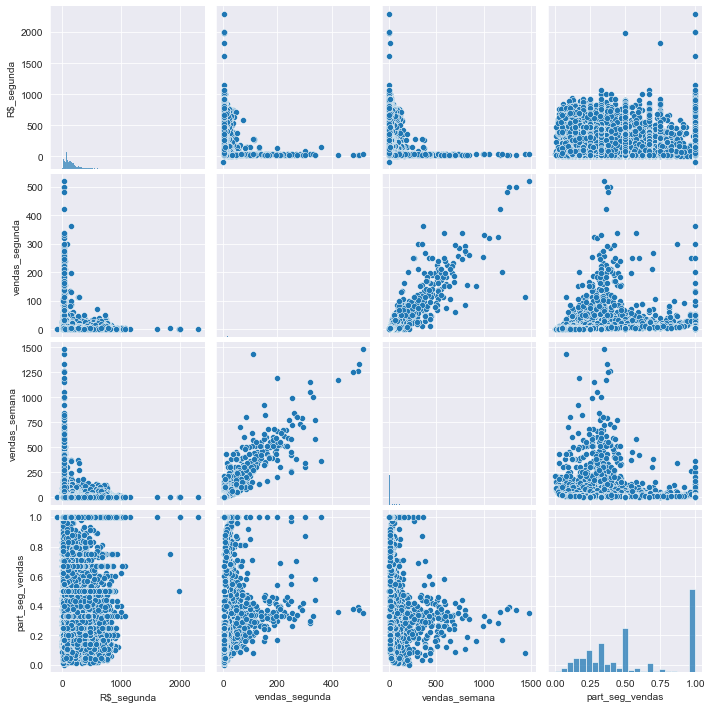

In [701]:
# Analisando a correlação das variáveis numéricas
sns.set_style('darkgrid')
sns.pairplot(df_final)

# vendas_semana e vendas_segunda tem correlação, porém, vendas_semana é o que eu quero prever e não vai entrar no modelo.
# assim, a correlação das variáveis numéricas é boa para entrar no modelo

# Aplicando o Modelo de previsão

In [702]:
# vendas_semana não entra no modelo de previsão
teste = df_f[[ 'Código', 'MÉDIO_CANAL', 'feriado', 'semana_mês', 'Mês', 'R$_segunda', 'vendas_segunda', 'part_seg_vendas' ]]

In [704]:
test_cat_vars = list(teste.select_dtypes('object').columns)
test_num_vars = list(teste.select_dtypes(include=np.number).columns)
test_num_vars.pop()

In [710]:
X_train, X_test, y_train, y_test = train_test_split(teste, 
                                                    df_final['part_seg_vendas'], 
                                                    test_size = 0.2, random_state = 42)

In [711]:
scaler = StandardScaler()
scaler.fit(X_train[test_num_vars])

StandardScaler()

In [717]:
X_train_t = pd.DataFrame(scaler.transform(X_train[test_num_vars]), columns = test_num_vars).join(X_train[test_cat_vars], on = X_train.index)
X_test_t = pd.DataFrame(scaler.transform(X_test[test_num_vars]), columns = test_num_vars).join(X_test[test_cat_vars], on = X_test.index)

In [718]:
cat_fit = cat.CatBoostRegressor(use_best_model = True,
                                iterations = 30000, 
                                depth = 12, 
                                learning_rate = 0.1,
                                od_type = "Iter", 
                                od_wait = 500)

cat_fit.fit(X_train_t, y_train, cat_features=test_cat_vars, eval_set = (X_test_t, y_test))

0:	learn: 0.3172066	test: 0.3178799	best: 0.3178799 (0)	total: 230ms	remaining: 1h 55m 4s
1:	learn: 0.3105365	test: 0.3112309	best: 0.3112309 (1)	total: 375ms	remaining: 1h 33m 51s
2:	learn: 0.3049334	test: 0.3054612	best: 0.3054612 (2)	total: 506ms	remaining: 1h 24m 24s
3:	learn: 0.2999430	test: 0.3005479	best: 0.3005479 (3)	total: 668ms	remaining: 1h 23m 31s
4:	learn: 0.2943350	test: 0.2946033	best: 0.2946033 (4)	total: 845ms	remaining: 1h 24m 30s
5:	learn: 0.2899318	test: 0.2897408	best: 0.2897408 (5)	total: 874ms	remaining: 1h 12m 51s
6:	learn: 0.2861944	test: 0.2859353	best: 0.2859353 (6)	total: 903ms	remaining: 1h 4m 29s
7:	learn: 0.2828764	test: 0.2823987	best: 0.2823987 (7)	total: 944ms	remaining: 58m 58s
8:	learn: 0.2803502	test: 0.2798588	best: 0.2798588 (8)	total: 975ms	remaining: 54m 7s
9:	learn: 0.2774771	test: 0.2771894	best: 0.2771894 (9)	total: 1.14s	remaining: 57m
10:	learn: 0.2755455	test: 0.2752444	best: 0.2752444 (10)	total: 1.2s	remaining: 54m 20s
11:	learn: 0.2733

91:	learn: 0.2256818	test: 0.2568660	best: 0.2568587 (78)	total: 13.1s	remaining: 1h 10m 57s
92:	learn: 0.2253592	test: 0.2568461	best: 0.2568461 (92)	total: 13.2s	remaining: 1h 11m
93:	learn: 0.2249159	test: 0.2566972	best: 0.2566972 (93)	total: 13.4s	remaining: 1h 11m 9s
94:	learn: 0.2245091	test: 0.2566551	best: 0.2566551 (94)	total: 13.6s	remaining: 1h 11m 14s
95:	learn: 0.2236939	test: 0.2566345	best: 0.2566345 (95)	total: 13.7s	remaining: 1h 11m 18s
96:	learn: 0.2236855	test: 0.2566259	best: 0.2566259 (96)	total: 13.8s	remaining: 1h 10m 40s
97:	learn: 0.2233670	test: 0.2566410	best: 0.2566259 (96)	total: 13.9s	remaining: 1h 10m 41s
98:	learn: 0.2229521	test: 0.2565671	best: 0.2565671 (98)	total: 14.1s	remaining: 1h 10m 45s
99:	learn: 0.2227444	test: 0.2565119	best: 0.2565119 (99)	total: 14.2s	remaining: 1h 10m 44s
100:	learn: 0.2227436	test: 0.2565110	best: 0.2565110 (100)	total: 14.2s	remaining: 1h 10m 7s
101:	learn: 0.2221864	test: 0.2565324	best: 0.2565110 (100)	total: 14.4s	r

179:	learn: 0.1999596	test: 0.2562321	best: 0.2560691 (156)	total: 26.3s	remaining: 1h 12m 44s
180:	learn: 0.1995108	test: 0.2563043	best: 0.2560691 (156)	total: 26.5s	remaining: 1h 12m 46s
181:	learn: 0.1989801	test: 0.2562664	best: 0.2560691 (156)	total: 26.7s	remaining: 1h 12m 48s
182:	learn: 0.1987913	test: 0.2562783	best: 0.2560691 (156)	total: 26.8s	remaining: 1h 12m 49s
183:	learn: 0.1982906	test: 0.2562718	best: 0.2560691 (156)	total: 27s	remaining: 1h 12m 50s
184:	learn: 0.1980739	test: 0.2562584	best: 0.2560691 (156)	total: 27.1s	remaining: 1h 12m 52s
185:	learn: 0.1978883	test: 0.2562127	best: 0.2560691 (156)	total: 27.3s	remaining: 1h 12m 53s
186:	learn: 0.1977719	test: 0.2562408	best: 0.2560691 (156)	total: 27.5s	remaining: 1h 12m 56s
187:	learn: 0.1975007	test: 0.2562943	best: 0.2560691 (156)	total: 27.6s	remaining: 1h 12m 56s
188:	learn: 0.1969926	test: 0.2563740	best: 0.2560691 (156)	total: 27.7s	remaining: 1h 12m 56s
189:	learn: 0.1967691	test: 0.2563786	best: 0.256069

266:	learn: 0.1787157	test: 0.2565533	best: 0.2560691 (156)	total: 40.8s	remaining: 1h 15m 47s
267:	learn: 0.1784103	test: 0.2565629	best: 0.2560691 (156)	total: 41s	remaining: 1h 15m 47s
268:	learn: 0.1782280	test: 0.2565727	best: 0.2560691 (156)	total: 41.2s	remaining: 1h 15m 48s
269:	learn: 0.1779182	test: 0.2566487	best: 0.2560691 (156)	total: 41.3s	remaining: 1h 15m 48s
270:	learn: 0.1777274	test: 0.2566546	best: 0.2560691 (156)	total: 41.5s	remaining: 1h 15m 47s
271:	learn: 0.1773731	test: 0.2566374	best: 0.2560691 (156)	total: 41.6s	remaining: 1h 15m 47s
272:	learn: 0.1770937	test: 0.2566628	best: 0.2560691 (156)	total: 41.8s	remaining: 1h 15m 46s
273:	learn: 0.1768227	test: 0.2566927	best: 0.2560691 (156)	total: 41.9s	remaining: 1h 15m 45s
274:	learn: 0.1764705	test: 0.2566418	best: 0.2560691 (156)	total: 42.1s	remaining: 1h 15m 47s
275:	learn: 0.1762100	test: 0.2566562	best: 0.2560691 (156)	total: 42.2s	remaining: 1h 15m 47s
276:	learn: 0.1759666	test: 0.2566833	best: 0.256069

353:	learn: 0.1589617	test: 0.2571220	best: 0.2560691 (156)	total: 54.8s	remaining: 1h 16m 25s
354:	learn: 0.1588807	test: 0.2571135	best: 0.2560691 (156)	total: 54.9s	remaining: 1h 16m 25s
355:	learn: 0.1585489	test: 0.2571246	best: 0.2560691 (156)	total: 55.1s	remaining: 1h 16m 26s
356:	learn: 0.1583312	test: 0.2571262	best: 0.2560691 (156)	total: 55.3s	remaining: 1h 16m 28s
357:	learn: 0.1581819	test: 0.2571442	best: 0.2560691 (156)	total: 55.4s	remaining: 1h 16m 27s
358:	learn: 0.1580339	test: 0.2571565	best: 0.2560691 (156)	total: 55.6s	remaining: 1h 16m 27s
359:	learn: 0.1578815	test: 0.2571167	best: 0.2560691 (156)	total: 55.7s	remaining: 1h 16m 29s
360:	learn: 0.1575429	test: 0.2571251	best: 0.2560691 (156)	total: 55.9s	remaining: 1h 16m 28s
361:	learn: 0.1574038	test: 0.2570997	best: 0.2560691 (156)	total: 56s	remaining: 1h 16m 28s
362:	learn: 0.1573130	test: 0.2571088	best: 0.2560691 (156)	total: 56.2s	remaining: 1h 16m 27s
363:	learn: 0.1569362	test: 0.2571233	best: 0.256069

441:	learn: 0.1414177	test: 0.2577687	best: 0.2560691 (156)	total: 1m 9s	remaining: 1h 16m 55s
442:	learn: 0.1413338	test: 0.2577595	best: 0.2560691 (156)	total: 1m 9s	remaining: 1h 16m 55s
443:	learn: 0.1411997	test: 0.2577720	best: 0.2560691 (156)	total: 1m 9s	remaining: 1h 16m 54s
444:	learn: 0.1410480	test: 0.2577833	best: 0.2560691 (156)	total: 1m 9s	remaining: 1h 16m 55s
445:	learn: 0.1408507	test: 0.2577957	best: 0.2560691 (156)	total: 1m 9s	remaining: 1h 16m 56s
446:	learn: 0.1407185	test: 0.2577779	best: 0.2560691 (156)	total: 1m 9s	remaining: 1h 16m 57s
447:	learn: 0.1406147	test: 0.2577771	best: 0.2560691 (156)	total: 1m 10s	remaining: 1h 16m 59s
448:	learn: 0.1405030	test: 0.2577809	best: 0.2560691 (156)	total: 1m 10s	remaining: 1h 16m 58s
449:	learn: 0.1402915	test: 0.2577764	best: 0.2560691 (156)	total: 1m 10s	remaining: 1h 16m 59s
450:	learn: 0.1399130	test: 0.2577823	best: 0.2560691 (156)	total: 1m 10s	remaining: 1h 16m 59s
451:	learn: 0.1396393	test: 0.2577877	best: 0.

529:	learn: 0.1258746	test: 0.2581178	best: 0.2560691 (156)	total: 1m 23s	remaining: 1h 17m 21s
530:	learn: 0.1257320	test: 0.2581115	best: 0.2560691 (156)	total: 1m 23s	remaining: 1h 17m 22s
531:	learn: 0.1254719	test: 0.2581000	best: 0.2560691 (156)	total: 1m 23s	remaining: 1h 17m 23s
532:	learn: 0.1254121	test: 0.2580980	best: 0.2560691 (156)	total: 1m 23s	remaining: 1h 17m 23s
533:	learn: 0.1251560	test: 0.2581256	best: 0.2560691 (156)	total: 1m 24s	remaining: 1h 17m 23s
534:	learn: 0.1249695	test: 0.2581554	best: 0.2560691 (156)	total: 1m 24s	remaining: 1h 17m 23s
535:	learn: 0.1249182	test: 0.2581526	best: 0.2560691 (156)	total: 1m 24s	remaining: 1h 17m 24s
536:	learn: 0.1247164	test: 0.2581593	best: 0.2560691 (156)	total: 1m 24s	remaining: 1h 17m 24s
537:	learn: 0.1245957	test: 0.2581592	best: 0.2560691 (156)	total: 1m 24s	remaining: 1h 17m 24s
538:	learn: 0.1244086	test: 0.2581512	best: 0.2560691 (156)	total: 1m 24s	remaining: 1h 17m 25s
539:	learn: 0.1242269	test: 0.2581507	be

615:	learn: 0.1117360	test: 0.2586528	best: 0.2560691 (156)	total: 1m 38s	remaining: 1h 18m 2s
616:	learn: 0.1115552	test: 0.2586851	best: 0.2560691 (156)	total: 1m 38s	remaining: 1h 18m 3s
617:	learn: 0.1112797	test: 0.2587052	best: 0.2560691 (156)	total: 1m 38s	remaining: 1h 18m 3s
618:	learn: 0.1111826	test: 0.2587094	best: 0.2560691 (156)	total: 1m 38s	remaining: 1h 18m 2s
619:	learn: 0.1110587	test: 0.2587307	best: 0.2560691 (156)	total: 1m 38s	remaining: 1h 18m 2s
620:	learn: 0.1107751	test: 0.2587314	best: 0.2560691 (156)	total: 1m 38s	remaining: 1h 18m 1s
621:	learn: 0.1105954	test: 0.2587127	best: 0.2560691 (156)	total: 1m 39s	remaining: 1h 18m 1s
622:	learn: 0.1104766	test: 0.2587255	best: 0.2560691 (156)	total: 1m 39s	remaining: 1h 18m
623:	learn: 0.1103738	test: 0.2587408	best: 0.2560691 (156)	total: 1m 39s	remaining: 1h 18m 1s
624:	learn: 0.1101058	test: 0.2587017	best: 0.2560691 (156)	total: 1m 39s	remaining: 1h 18m
625:	learn: 0.1100449	test: 0.2587029	best: 0.2560691 (1

# Criando o DF de entrada para fazer as previsões

In [719]:
mask_ontem = ecm_vendas['data'] == ontem
df_ontem = ecm_vendas[mask_ontem]

df_pred = df_ontem.groupby(by = ['data', 'MÉDIO_CANAL', 'Código'], as_index=False).agg(
    R_segunda = pd.NamedAgg(column = 'Vr Unitário', aggfunc='mean'),
    vendas_segunda = pd.NamedAgg(column = 'Volume / Mês', aggfunc='sum'))

In [720]:
df_pred = df_pred.rename(columns = {'R_segunda' : 'R$_segunda'})
df_pred['R$_segunda'] = df_pred['R$_segunda'].round(2)
#Criando a coluna mês
df_pred['Mês'] = df_pred['data'].apply(lambda x: x.month)

In [721]:
# Criando coluna com a semana do ano
df_pred['semana'] = df_pred['data'].apply(lambda x: x.strftime("%U"))
df_pred['semana'] = df_pred['semana'].map(int)
# Criando coluna com o dia 1 do mês de cada pedido
df_pred['dia1_do_mês'] = [(data - (timedelta(data.day - 1))) for data in df_pred['data']]
# Criando coluna com a semana do ano dia 1 daquele mês
df_pred['semana_ano_dia1'] = [x.strftime("%U") for x in df_pred['dia1_do_mês']]
df_pred['semana_ano_dia1'] = df_pred['semana_ano_dia1'].map(int)
# Criando coluna com o dia da semana do mês
df_pred['weekday_dia1'] = df_pred['dia1_do_mês'].apply(lambda x: x.weekday())


# Considerar primeira semana do mês apenas quando o primeiro dia da semana for segunda ou terça
# Caso não seja, desconsiderar a primeira semana e manter a semana 2 como a primeira semana útil de compras
# Em resumo, estamos considerando que a primeira segunda ou terça de cada mês caracteriza a semana 1 do mês
def func_semana_corrigida(col1, col2):
    if col1 == 6:
        return col2
    elif col1 > 1:
        return col2 - 1
    else:
        return col2

df_pred['semana_ano_corrigida'] = df_pred.apply(lambda x: func_semana_corrigida(x.weekday_dia1, x.semana), axis = 1)

# Agora vamos subtrair a semana_ano_corrigida, pela semana_no_dia1 e somar uma
# Com essa fórmula chegaremos a semana do mês que as compras foram feitas.
def func_semana(col1, col2):
    return col1 - col2 + 1

df_pred['semana_mês'] = df_pred.apply(lambda x: func_semana(x.semana_ano_corrigida, x.semana_ano_dia1), axis = 1)

# Criar a coluna feriado
df_pred['feriado'] = 0
df_pred.loc[(df_f['Ano'] == hoje.year) & (df_f['semana'] == '09'), 'feriado'] = 1
df_pred.loc[(df_f['Ano'] == hoje.year) & (df_f['semana'] == '46'), 'feriado'] = 1

In [722]:
df_pred_final = df_pred[[ 'Código', 'MÉDIO_CANAL', 'R$_segunda', 'vendas_segunda', 'Mês', 'feriado', 'semana_mês' ]]
df_pred_final['Mês'] = df_pred_final['Mês'].map(str)
df_pred_final['feriado'] = df_pred_final['feriado'].map(str)
df_pred_final['semana_mês'] = df_pred_final['semana_mês'].map(str)

<ipython-input-722-4e67885111fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_final['Mês'] = df_pred_final['Mês'].map(str)
<ipython-input-722-4e67885111fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_final['feriado'] = df_pred_final['feriado'].map(str)
<ipython-input-722-4e67885111fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [723]:
df_pred_final['prev_part_seg'] = cat_fit.predict(df_pred_final[cat_fit.feature_names_])

<ipython-input-723-9e73b26f2c4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_final['prev_part_seg'] = cat_fit.predict(df_pred_final[cat_fit.feature_names_])


In [750]:
df_pred_final

,Código,MÉDIO_CANAL,R$_segunda,vendas_segunda,Mês,feriado,semana_mês,previsão demanda
0,100498,AMAZON,141.44,1.0,4,0,4,1.0
1,100499,AMAZON,144.73,1.0,4,0,4,2.0
2,100681,AMAZON,199.78,1.0,4,0,4,2.0
3,100840,AMAZON,195.83,1.0,4,0,4,2.0
4,100957,AMAZON,31.66,13.0,4,0,4,24.0
...,...,...,...,...,...,...,...,...
338,121122,SITE,727.39,1.0,4,0,4,1.0
339,121604,SITE,45.82,1.0,4,0,4,1.0
340,122655,SITE,155.31,1.0,4,0,4,1.0
341,124398,SITE,171.65,1.0,4,0,4,1.0


In [725]:
df_pred_final['previsão demanda'] = round((df_pred_final['vendas_segunda'] / df_pred_final['prev_part_seg']),0)

<ipython-input-725-ea8fb819f6b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_final['previsão demanda'] = round((df_pred_final['vendas_segunda'] / df_pred_final['prev_part_seg']),0)


In [729]:
df_pred_final = df_pred_final.drop(columns = 'prev_part_seg')

In [749]:
df_pred_final[df_pred_final['Código'] == '100097']

,Código,MÉDIO_CANAL,R$_segunda,vendas_segunda,Mês,feriado,semana_mês,previsão demanda
76,100097,MERCADO LIVRE,553.14,14.0,4,0,4,35.0
131,100097,MERCADO LIVRE FULL,654.14,18.0,4,0,4,47.0
237,100097,RMA,649.13,2.0,4,0,4,4.0
287,100097,SITE,180.00,1.0,4,0,4,3.0


# Comparando a previsão com os valores reais

In [736]:
mask_confirm = ecm_full['Data Emissão'] > '2022-04-24'
df_c = ecm_full[mask_confirm]

mask_confirm_1 = df_c['Data Emissão'] < '2022-04-30'
df_c = df_c[mask_confirm_1]

In [742]:
df_ve_re = df_c.groupby(by = ['Código', 'MÉDIO_CANAL'], as_index = False).agg( Vendas_reais = pd.NamedAgg(column = 'Volume / Mês', 
                                                                                               aggfunc = 'sum'))

In [744]:
df_wMAPE = df_pred_final.merge(df_ve_re, on = ['Código', 'MÉDIO_CANAL'], how = 'left')

In [751]:
df_wMAPE[df_wMAPE['Código'] == '100097']

,Código,MÉDIO_CANAL,R$_segunda,vendas_segunda,Mês,feriado,semana_mês,previsão demanda,Vendas_reais
76,100097,MERCADO LIVRE,553.14,14.0,4,0,4,35.0,14.0
131,100097,MERCADO LIVRE FULL,654.14,18.0,4,0,4,47.0,57.0
237,100097,RMA,649.13,2.0,4,0,4,4.0,2.0
287,100097,SITE,180.00,1.0,4,0,4,3.0,1.0


# Calculando o wMAPE para ver a assertividade real do modelo

In [752]:
df_wMAPE['erro_absoluto'] = df_wMAPE['Vendas_reais'] - df_wMAPE['previsão demanda']

In [753]:
df_wMAPE

,Código,MÉDIO_CANAL,R$_segunda,vendas_segunda,Mês,feriado,semana_mês,previsão demanda,Vendas_reais,erro_absoluto
0,100498,AMAZON,141.44,1.0,4,0,4,1.0,2.0,1.0
1,100499,AMAZON,144.73,1.0,4,0,4,2.0,2.0,0.0
2,100681,AMAZON,199.78,1.0,4,0,4,2.0,7.0,5.0
3,100840,AMAZON,195.83,1.0,4,0,4,2.0,2.0,0.0
4,100957,AMAZON,31.66,13.0,4,0,4,24.0,13.0,-11.0
...,...,...,...,...,...,...,...,...,...,...
338,121122,SITE,727.39,1.0,4,0,4,1.0,1.0,0.0
339,121604,SITE,45.82,1.0,4,0,4,1.0,1.0,0.0
340,122655,SITE,155.31,1.0,4,0,4,1.0,1.0,0.0
341,124398,SITE,171.65,1.0,4,0,4,1.0,1.0,0.0


In [758]:
Erro = df_wMAPE['erro_absoluto'].sum() / df_wMAPE['Vendas_reais'].sum()

In [762]:
print(f'''Erro Percentual Absoluto Médio Ponderado: {(Erro).round(2)}
Assertividade wMAPE do modelo foi de: {(1 - Erro).round(2)}
erro calculado na semana de 25/04 à 29/04''')

Erro Percentual Absoluto Médio Ponderado: 0.35
Assertividade wMAPE do modelo foi de: 0.65
erro calculado na semana de 25/04 à 29/04


# Juntando a previsão ao DF principal

In [770]:
df_merge = df_wMAPE[[ 'Código', 'MÉDIO_CANAL', 'previsão demanda']]
df_merge = df_merge.rename(columns = {'MÉDIO_CANAL' : 'Canal'})

In [774]:
relatorio_segunda = relatorio_segunda.merge(df_merge, on = ['Código', 'Canal'], how = 'left')

In [775]:
relatorio_segunda

,Canal,Código,Vendas Ontem,Vendas 1seg,Vendas 2seg,Vendas 3seg,Preço Ontem,Preço 1seg,Preço 2seg,Preço 3seg,MC Ontem,MC 1seg,MC 2seg,MC 3seg,Diferença MC (Ontem / 1seg),previsão demanda
0,MERCADO LIVRE FULL,121465,2,12,9,8,703.14,742.72,742.72,738.71,290.84,2156.88,1777.28,1459.98,-1866.04,5.0
1,SITE,100763,1,9,3,5,258.95,258.95,258.95,258.95,92.67,900.58,256.33,478.89,-807.91,3.0
2,B2W,100763,3,12,11,9,289.48,278.20,278.20,278.20,237.74,800.32,749.45,546.37,-562.58,7.0
3,MERCADO LIVRE FULL,101000,10,23,15,7,78.57,78.57,78.57,78.57,176.31,556.41,278.31,130.01,-380.10,24.0
4,MERCADO LIVRE,100588,3,23,9,8,184.29,159.40,159.40,184.29,112.74,475.83,178.09,141.87,-363.09,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,MERCADO LIVRE,100059,1,19,2,1,447.17,471.40,471.40,677.36,8.21,-366.80,221.09,109.43,375.01,2.0
339,RMA,100097,2,0,0,1,649.13,0.00,0.00,754.29,430.48,0.00,0.00,320.21,430.48,4.0
340,MERCADO LIVRE FULL,100059,7,8,2,7,544.82,447.17,447.17,609.12,223.83,-224.42,252.72,466.40,448.25,18.0
341,REVENDA,100215,3,0,1,10,682.15,0.00,0.00,716.09,526.67,0.00,186.79,1482.01,526.67,6.0
